In [31]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches
from IPython.display import display



In [32]:
USE_GPU = True
TRAIN = True

In [33]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724574100.763106    4345 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724574100.764848    4345 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724574100.766043    4345 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724574100.767632    4345 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [34]:
IMAGE_SIZE = 24
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.002
EPOCHS = 52
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [35]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 22, 24), (2740,), (2740, 24, 24, 1))

In [36]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(24, 24, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 12, 12, 24)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 6, 6, 48)       │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 3, 3, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 2, 2, 192)      │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 2, 2, 384)      │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 1, 1, 1)        │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,057 (1.50 MB)

 Trainable params: 394,057 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=3, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=2, strides=1, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 1, 1, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 4, 4, 192)      │     1,769,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 192)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 4, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 96)       │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 8, 8, 48)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 24, 24, 24)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 24, 24, 24)     │         9,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │             

 Total params: 2,380,321 (9.08 MB)

 Trainable params: 2,379,649 (9.08 MB)

 Non-trainable params: 672 (2.62 KB)

In [38]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [39]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [40]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - c_gp: 0.4946 - c_loss: 3.0183 - c_wass_loss: -1.9274 - g_loss: 2.0280  

W0000 00:00:1724574171.964697    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.965326    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.966012    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.967322    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.968703    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.969683    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.970206    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.970737    4345 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724574171.971268    4345 gp

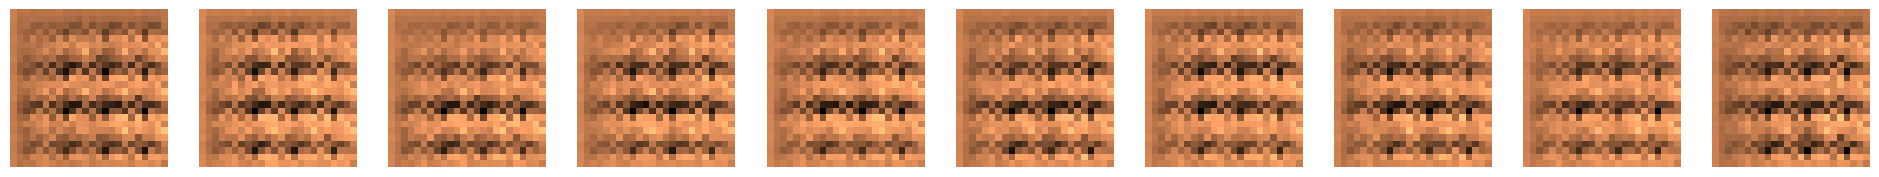

3/3 ━━━━━━━━━━━━━━━━━━━━ 71s 16s/step - c_gp: 0.4724 - c_loss: 2.2293 - c_wass_loss: -2.4946 - g_loss: 2.5498
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/55


/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.2851 - c_loss: -9.7849 - c_wass_loss: -12.6357 - g_loss: 15.0436
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - c_gp: 0.4001 - c_loss: -8.6002 - c_wass_loss: -12.6012 - g_loss: 8.4669

2024-08-25 09:22:52.653248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - c_gp: 0.3147 - c_loss: -8.3273 - c_wass_loss: -11.4741 - g_loss: 9.1234
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1383 - c_loss: -6.5420 - c_wass_loss: -7.9251 - g_loss: 9.8217 
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0876 - c_loss: -5.2621 - c_wass_loss: -6.1380 - g_loss: 6.0927
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - c_gp: 0.0654 - c_loss: -4.2875 - c_wass_loss: -4.9413 - g_loss: 4.0453

2024-08-25 09:22:53.798318: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-25 09:22:53.798385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - c_gp: 0.0635 - c_loss: -4.1197 - c_wass_loss: -4.7545 - g_loss: 3.9393

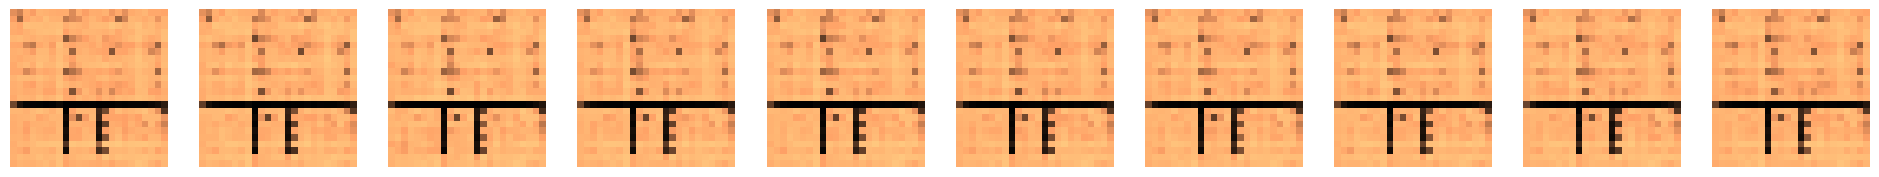

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - c_gp: 0.0627 - c_loss: -4.0774 - c_wass_loss: -4.7041 - g_loss: 3.8615
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.0520 - c_loss: -3.2079 - c_wass_loss: -3.7278 - g_loss: 2.8349
Epoch 14/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - c_gp: 0.0583 - c_loss: -2.5148 - c_wass_loss: -3.0981 - g_loss: 0.7930

2024-08-25 09:22:54.656246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0407 - c_loss: -2.4074 - c_wass_loss: -2.8146 - g_loss: 1.0632
Epoch 16/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - c_gp: 0.0192 - c_loss: -2.0748 - c_wass_loss: -2.2671 - g_loss: 2.1231
Epoch 18/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0109 - c_loss: -1.7927 - c_wass_loss: -1.9016 - g_loss: 0.1909 
Epoch 20/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 21/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - c_gp: 0.0216 - c_loss: -1.7261 - c_wass_loss: -1.9419 - g_loss: -0.8785

2024-08-25 09:22:55.804426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.0227 - c_loss: -1.6701 - c_wass_loss: -1.8969 - g_loss: -0.0821

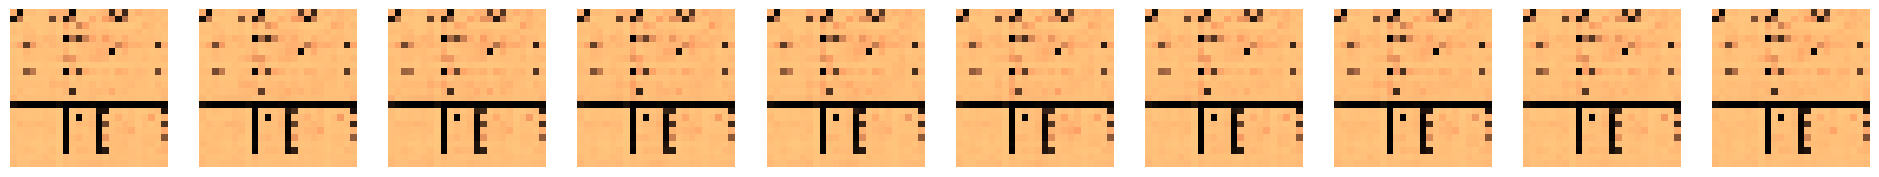

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - c_gp: 0.0227 - c_loss: -1.6650 - c_wass_loss: -1.8924 - g_loss: 0.0727 
Epoch 22/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - c_gp: 0.0103 - c_loss: -1.5428 - c_wass_loss: -1.6454 - g_loss: -0.0243
Epoch 24/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - c_gp: 0.0070 - c_loss: -1.3935 - c_wass_loss: -1.4635 - g_loss: 1.1660
Epoch 26/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.0145 - c_loss: -1.4968 - c_wass_loss: -1.6419 - g_loss: -0.2270
Epoch 28/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss:

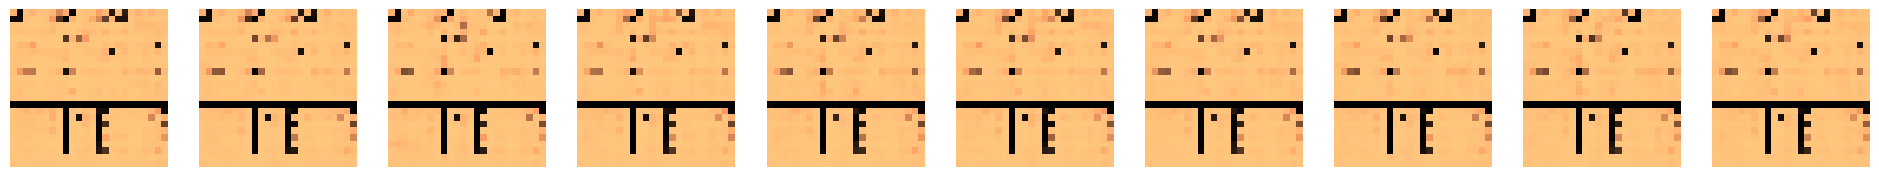

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - c_gp: 0.0243 - c_loss: -1.5935 - c_wass_loss: -1.8361 - g_loss: -4.1055
Epoch 32/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.0412 - c_loss: -1.4751 - c_wass_loss: -1.8869 - g_loss: -3.1826
Epoch 34/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0116 - c_loss: -1.6099 - c_wass_loss: -1.7264 - g_loss: 0.4725
Epoch 36/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0138 - c_loss: -1.0357 - c_wass_loss: -1.1738 - g_loss: 0.1179 
Epoch 38/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0

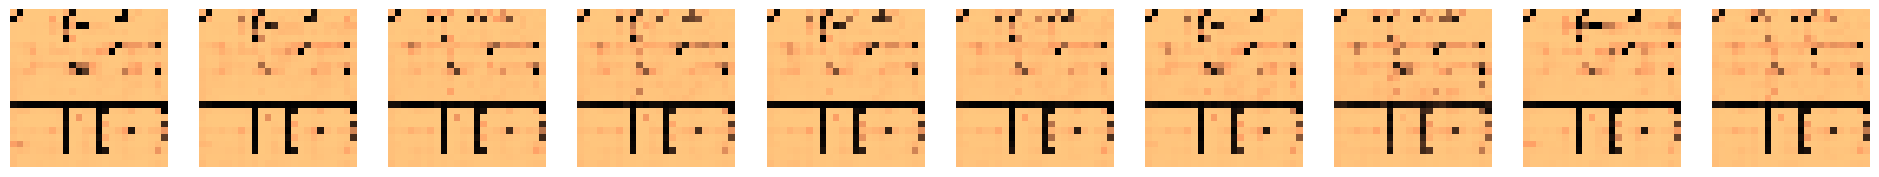

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - c_gp: 0.0283 - c_loss: -1.4607 - c_wass_loss: -1.7435 - g_loss: -3.7484
Epoch 42/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - c_gp: 0.0102 - c_loss: -1.5533 - c_wass_loss: -1.6554 - g_loss: -6.5496

2024-08-25 09:23:00.540569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0105 - c_loss: -1.4571 - c_wass_loss: -1.5619 - g_loss: -6.0139
Epoch 44/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0124 - c_loss: -0.9828 - c_wass_loss: -1.1063 - g_loss: -3.7985
Epoch 46/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - c_gp: 0.0166 - c_loss: -0.9065 - c_wass_loss: -1.0724 - g_loss: -5.1552

2024-08-25 09:23:01.308574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0169 - c_loss: -1.0802 - c_wass_loss: -1.2488 - g_loss: -5.7312
Epoch 48/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 49/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.0229 - c_loss: -1.4681 - c_wass_loss: -1.6969 - g_loss: -5.8745
Epoch 50/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 51/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0289 - c_loss: -1.2320 - c_wass_loss: -1.5215 - g_loss: -0.9000

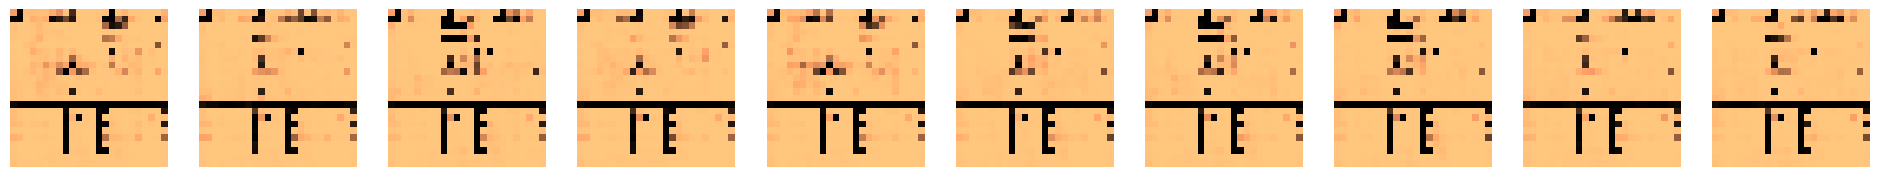

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - c_gp: 0.0292 - c_loss: -1.1816 - c_wass_loss: -1.4735 - g_loss: -1.0534
Epoch 52/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - c_gp: 0.0100 - c_loss: -0.8348 - c_wass_loss: -0.9350 - g_loss: -4.0365

2024-08-25 09:23:02.550398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17498014998619830067


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - c_gp: 0.0160 - c_loss: -0.9745 - c_wass_loss: -1.1348 - g_loss: -4.2221
Epoch 54/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - c_gp: 0.0233 - c_loss: -1.2967 - c_wass_loss: -1.5299 - g_loss: -1.1939


In [41]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


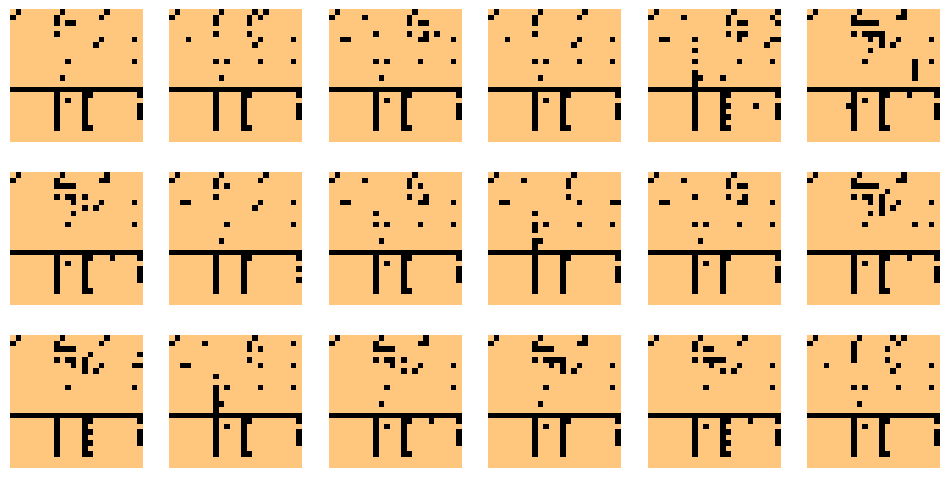

In [45]:
if TRAIN:
    
    noise = np.random.normal(size=(18, Z_DIM))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/language_phonemes_all.npz",
        generated_languages=generated_languages,
    )

else:
    data = np.load("./data/language_phonemes_all.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

    print(generated_languages.shape)

# normalise
generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
# sigmoid
generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

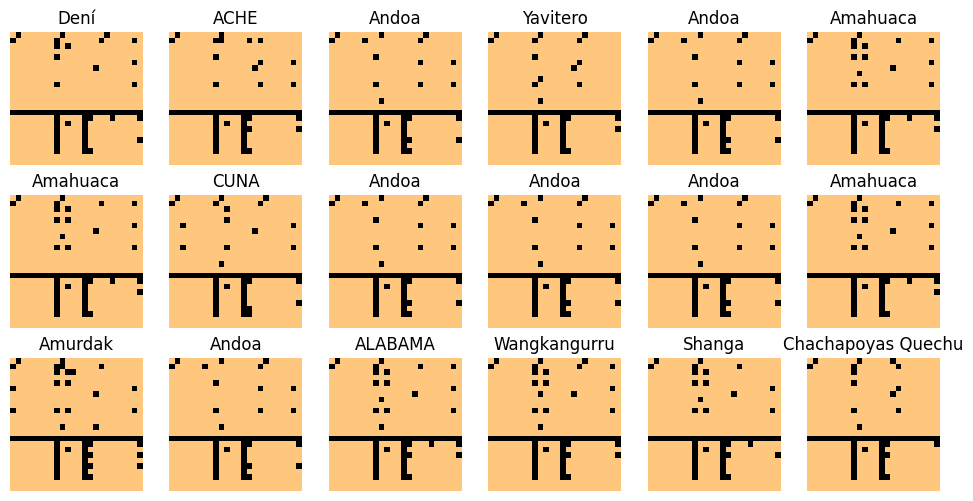

In [46]:
# find closest matches

closest_idx, closest = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

In [47]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

((14, 24), (7, 8), (3, 4), (7, 10))

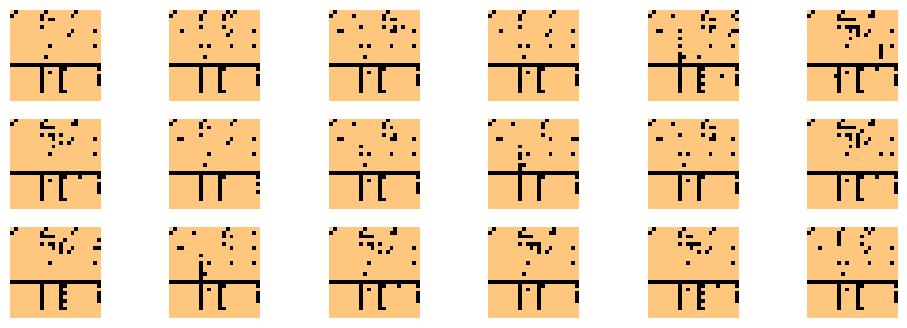

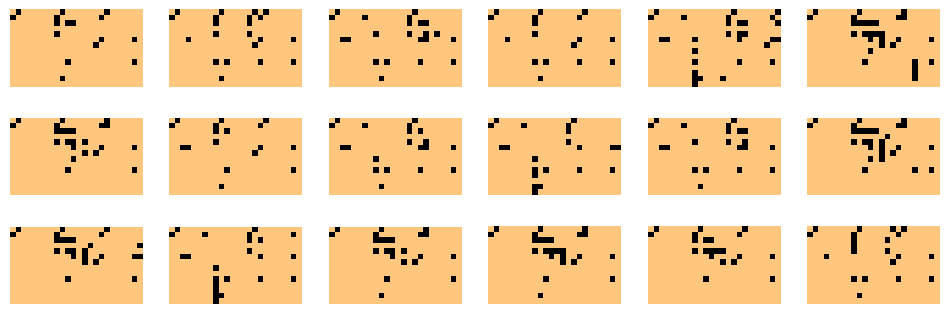

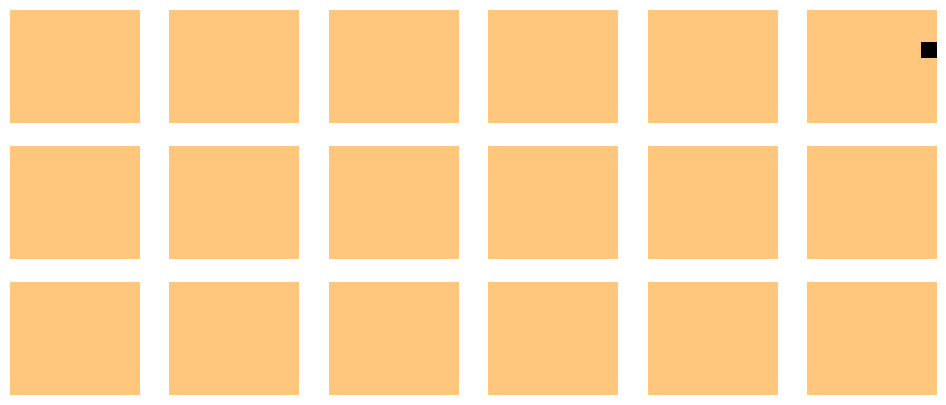

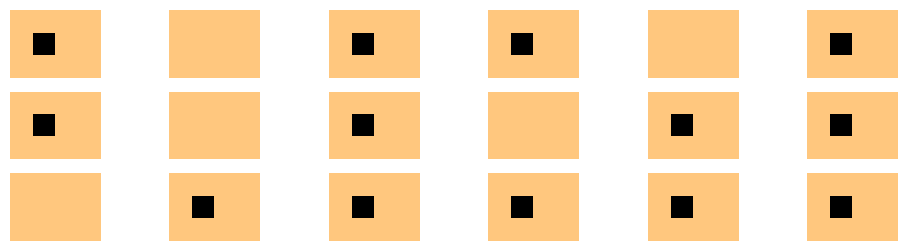

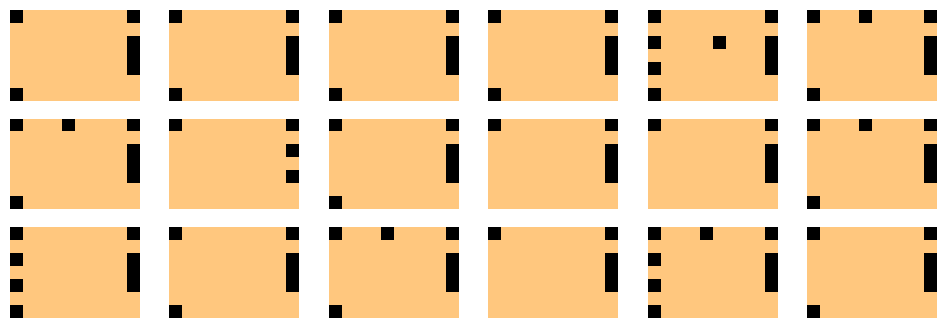

((18, 14, 24, 1), (18, 7, 8, 1), (18, 3, 4, 1), (18, 7, 10, 1))

In [48]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:8 :]
generated_cons_coart = generated_languages[:, 15:18, 9:13 :]
generated_vowels = generated_languages[:, 15:22, 14:24 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 4))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(12, 5))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(12, 3))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(12, 4))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [49]:
def create_ipa_table(lang, tbl):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    return pd.DataFrame(
        np.char.add(
            np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " ")),
            phonemes[:,1::2]
        ), 
        index=tbl.index, 
        columns=tbl.columns[0::2]
    )

sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[5]), cons_pl_tbl_df)

display(sample_cons_pl_tbl)

sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[5]), cons_npl_tbl_df)

display(sample_cons_npl_tbl)

sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[5]), cons_coart_tbl_df)

display(sample_cons_coart_tbl)

sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[5]), vowels_tbl_df)

display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ m,_ _,_ _,_ _,_ n,_ _,_ _,_ _,_ ŋ,_ _,_ _,_ _
Plosive,p _,_ _,_ _,_ _,t _,_ _,_ _,_ _,k ɡ,_ _,_ _,_ _
Sibilant affricate,_ _,_ _,_ _,_ _,ts dz,t̠ʃ d̠ʒ,tʂ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Sibilant fricative,_ _,_ _,_ _,_ _,s _,ʃ ʒ,ʂ ʐ,_ _,_ _,_ _,_ _,_ _
Non-sibilant fricative,_ _,_ _,_ _,_ _,_ _,_ ɹ̠˔,_ ɻ˔,_ _,x _,_ _,_ _,h _
Approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ ɻ,_ j,_ _,_ _,_ _,_ _
Tap/flap,_ _,_ _,_ _,_ _,_ _,_ *,_ _,_ _,_ _,_ _,_ _,_ _
Trill,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative,_ _,_ _,_ _,_ _,_ _,ʃ _,_ _,_ _,_ _,_ ʁ,_ _,h _


,0,2,4,6
Ejective Stop,_ _,_ _,_ _,_ _
Ejective Fricative,_ _,_ _,_ _,_ _
Ejective Affricate,_ _,_ _,_ _,_ *
Ejective Lateral,_ _,_ _,_ _,_ _
Click,_ _,_ _,_ _,_ _
Implosive Voiced,_ _,_ _,_ _,_ _
Implosive Voiceless,_ _,_ _,_ _,_ _


,Labial–palatal,Velarized alveolar
Fricative,_ _,_ _
Approximant,_ w,_ _
Lateral approximant,_ _,_ _


,Front unrounded,Near-front unrounded,Central unrounded,Near-back unrounded,Back unrounded
Close,i _,_ _,ɨ _,_ _,_ u
Near-close,_ _,_ _,_ _,_ _,_ _
Close-mid,_ _,_ _,_ _,_ _,_ o
Mid,_ _,_ _,_ _,_ _,_ o̞
Open-mid,_ _,_ _,_ _,_ _,_ ɔ
Near-open,_ _,_ _,_ _,_ _,_ _
Open,a _,_ _,_ _,_ _,_ _
